In [3]:
import itertools
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from sklearn.metrics import brier_score_loss, mean_squared_error

In [59]:
# Sklearnpool_detrend_seed2
distances = '/nobackup_1/users/straaten/match/paper3-4-4regimes_z-anom_JJA_45r1_1D-frequency_distances.h5'
id_path = '/nobackup_1/users/straaten/match/paper3-4-4regimes_z-anom_JJA_45r1_1D-frequency_ids.h5'
distances = pd.read_hdf(distances)
ids = pd.read_hdf(id_path)
code_table = pd.Series(['None','SNAO-/GB','SNAO+/AR','Atlow','block'], pd.Index(range(-1,4), name = 'clustid'), name = 'alias')

In [70]:
# Sklearnpool_detrend_seed1
distances = '/nobackup_1/users/straaten/match/paper3-4-5regimes_z-anom_JJA_45r1_1D-frequency_distances.h5'
id_path = '/nobackup_1/users/straaten/match/paper3-4-5regimes_z-anom_JJA_45r1_1D-frequency_ids.h5'
distances = pd.read_hdf(distances)
ids = pd.read_hdf(id_path)
code_table = pd.Series(['None','SNAO-/GB','diff_block','SNAO+/AR','block','Atlow'], pd.Index(range(-1,5), name = 'clustid'), name = 'alias')


### Distance to clusters
Should not be a linear function of time (regimes are on detrended data), can have variability in time of course: 

*However, the relative frequency of each jet regime exhibits a pronounced multiyear/decadal variability over the twentieth century. This might be further evidence for the suggested paradigm that the time-mean response of a system
to some imposed (internal or external) forcing manifests itself through a change in regime frequencies (Palmer, 1999; Corti et al. 1999)*

We also expect it to be a function of leadtime. Initialization -> drift towards model space that stops resembling (all or some of) the observed regimes.

In [5]:
dist_ftime = distances.loc[:,['time','clustid','observation']].drop_duplicates().set_index(['time','clustid']).unstack('clustid')

<AxesSubplot:xlabel='time'>

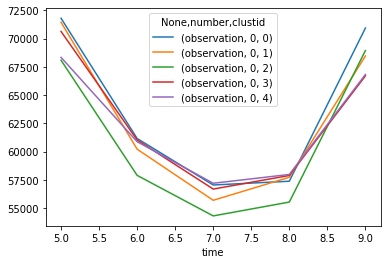

In [6]:
dist_ftime.groupby(dist_ftime.index.month).mean().plot()

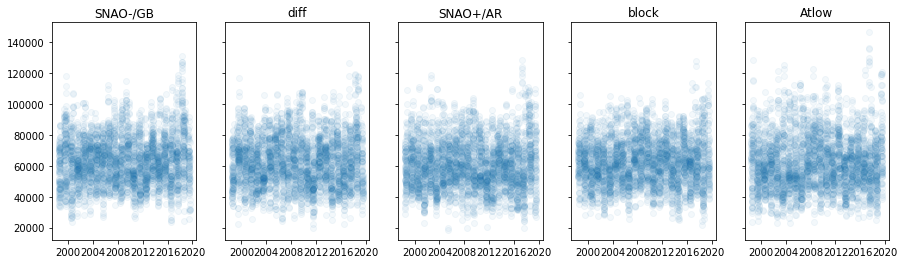

In [7]:
fig, axes = plt.subplots(ncols = len(dist_ftime.columns), figsize = (15,4), sharey = True)
for i, key in enumerate(dist_ftime.columns):
    axes[i].scatter(x = dist_ftime.index, y = dist_ftime[key], alpha = 0.05)
    axes[i].set_title(f'{code_table.loc[i]}')

array([[<AxesSubplot:title={'center':"('observation', 0, 0)"}>,
        <AxesSubplot:title={'center':"('observation', 0, 1)"}>],
       [<AxesSubplot:title={'center':"('observation', 0, 2)"}>,
        <AxesSubplot:title={'center':"('observation', 0, 3)"}>],
       [<AxesSubplot:title={'center':"('observation', 0, 4)"}>,
        <AxesSubplot:>]], dtype=object)

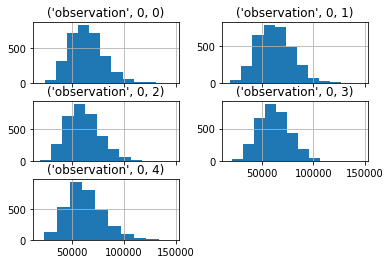

In [8]:
dist_ftime.hist(sharex = True)

Observed distances have the mean around 60000. Forecast distances a tiny bit higher. It used to be a lot lower, which had to do with faulty projection. And perhaps a very tiny part of the difference is that the forecast field is more 'smeared out' in comparison with the from highres resampled observations

In [9]:
distances.groupby('clustid').apply(lambda df: df.mean(axis = 0))

/tmp/ipykernel_2518888/2808063067.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  distances.groupby('clustid').apply(lambda df: df.mean(axis = 0))


clustid   leadtime      forecast                              \
number                                 0             1             2   
clustid                                                                
0           0.0  24.659157  62907.268402  63595.034790  63652.113983   
1           1.0  24.659157  63694.141589  64592.505827  64516.294895   
2           2.0  24.659157  60424.833463  60724.297492  60714.202142   
3           3.0  24.659157  62174.115858  62614.337530  62750.306051   
4           4.0  24.659157  60545.764616  60427.461817  60502.614222   

                                                                               \
number              3             4             5             6             7   
clustid                                                                         
0        63553.595147  63619.867903  63436.729541  63694.786150  63676.513292   
1        64420.075236  64185.412108  64100.083654  64478.145798  64626.530674   
2        60663.822448  60557.730348  60757.009093  60779.409169  60713.225058   
3        62854.295282  62659.059749  62565.569719  62743.907743  62756.577278   
4        60832.123415  60857.685204  60733.294142  60643.941139  60639.429493   

                                                    observation  
number              8             9            10             0  
clustid                                                          
0        63369.976159  63894.317828  63554.089623  62400.966901  
1        64373.378367  64772.852118  64446.598726  61637.581847  
2        60673.522265  60935.567172  60931.475529  59427.526309  
3        62774.213105  63012.974223  62768.202522  61630.562474  
4        60971.915037  60922.163021  60916.077862  61089.271249

In [10]:
dist_fleadtime = distances.loc[:,['clustid','time','leadtime','forecast']].set_index(['clustid','leadtime'])
dist_fleadtime['ensmean'] = dist_fleadtime['forecast'].mean(axis = 1)

<AxesSubplot:xlabel='leadtime'>

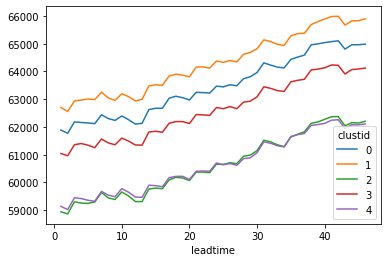

In [11]:
dist_fleadtime['ensmean'].groupby(['clustid','leadtime']).mean().unstack('clustid').plot()

This looks like a pretty stable stratification. The order of of distances corresponds pretty well to the order of mean distance in observations.

### Assigned clusters
Assigned to minimum distance, given the fact that this minimum is below the allowed maximum of 60000.

We expect a preferential assignment with leadtime. Certainly that we have more NO regimes (as distances increase with leadtime).

In [16]:
np.unique(ids['observation'], return_counts = True)

(array([-1,  0,  1,  2,  3,  4]), array([3731, 5479, 6863, 7987, 5340, 8509]))

In [21]:
forecast_freqs = ids.groupby('leadtime').apply(lambda df: pd.Series(np.unique(df['forecast'], return_counts = True)[-1] / df['forecast'].size, index = code_table.index))
obs_freqs = pd.Series(np.unique(ids['observation'], return_counts = True)[-1] / len(ids), index = code_table.index)

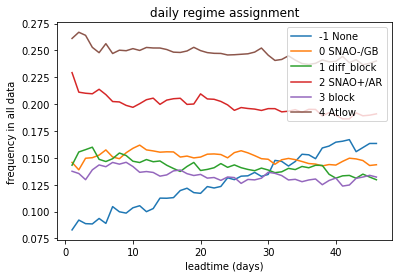

In [22]:
fig, ax = plt.subplots()
for clustid in obs_freqs.index:
    ax.plot(forecast_freqs.index, forecast_freqs.loc[:,clustid], label = f'{clustid} {code_table.loc[clustid]}')
ax.legend()
ax.set_ylabel('frequency in all data')
ax.set_xlabel('leadtime (days)')
ax.set_title('daily regime assignment')
plt.show()

Text(0.5, 0.98, 'Frequency of daily assignment')

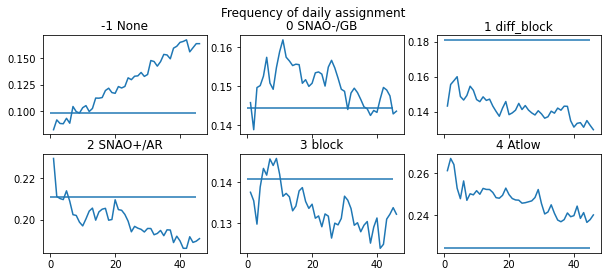

In [23]:
# Better look at the trends
fig, axes = plt.subplots(nrows = 2, ncols=3, squeeze = False, sharex = True, figsize = (10,4))
for i, clustid in enumerate(obs_freqs.index):
    ax = axes[i//3,i%3]
    im = ax.plot(forecast_freqs.index, forecast_freqs.loc[:,clustid], label = clustid)
    ax.set_title(f'{clustid} {code_table.loc[clustid]}')
    ax.hlines(y = obs_freqs.loc[clustid], xmin = 0, xmax = 45)
plt.suptitle('Frequency of daily assignment')

Overall these frequencies are pretty close (i.e. climatologically reliable). Of course it could still be that conditionally that are more off. Can we verify these?

In [24]:
scores = pd.Series(np.nan, index = pd.MultiIndex.from_product([ids.leadtime.unique(),code_table.index], names = ['leadtime','clustid']))
climscores = pd.Series(np.nan, index = code_table.index)
for leadtime, clustid in scores.index:
    subset = ids.loc[(ids['leadtime'] == leadtime).values,:]
    pi = ((subset['forecast'] == clustid).sum(axis = 1))/11 # + 0.5) / 12
    oi = (subset['observation'] == clustid)
    scores.loc[(leadtime,clustid)] = brier_score_loss(y_true = oi, y_prob=pi)
    climscores.loc[clustid] = brier_score_loss(oi, np.full(oi.shape, fill_value = obs_freqs.loc[clustid]))
scores = scores.unstack('clustid')
assert climscores.index.equals(scores.columns)
bss = pd.DataFrame(1 - scores.values / climscores.values[np.newaxis, :], columns = scores.columns, index = scores.index)

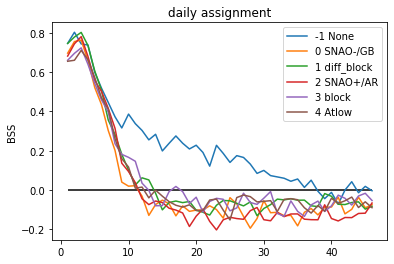

In [25]:
fig, ax = plt.subplots()
ax.hlines(y = 0, xmin = bss.index.min(), xmax = bss.index.max(), color = 'black')
for clustid in scores.columns:
    ax.plot(bss.index, bss.loc[:,clustid], label = f'{clustid} {code_table.loc[clustid]}')
ax.legend()
ax.set_ylabel('BSS')
ax.set_title('daily assignment')
plt.show()

This verification happens on a day by day basis. We expect a bit more scale when less sensitive to timing. We also expect for instance that the timeseries will be of higher use when the period matches the predictand period.

### Aggregating the predictions.
In a window we have no single observation anymore, but also a distribution of regimes over time. We can collapse the problem into the divergence between two (5 category) histograms, disregarding timing.

When counting the occurrences in forecasts this means that a few days with 100% chance is equivalent to each day a small chance.

Requires a 2D rolling in time and leadtime. Basically: for all timesteps we want to find the (multiple) leadtimes forecasting that timestep, join for each of those the subsequent leadtimes.

In [71]:
agg_id_path = '_'.join(id_path.split('_')[:-2] + ['21D-frequency_ids.h5'])
agg_ids = pd.read_hdf(agg_id_path)
agg_ids.columns = agg_ids.columns.droplevel('number')
agg_ids = agg_ids.set_index(['time','leadtime','clustid']).unstack('clustid')

In [72]:
obs_freqs_agg = agg_ids['observation'].mean(axis = 0)

In [73]:
def ranked_prob_skill(forecasts : np.ndarray, observations: np.ndarray):
    """
    Both arrays should be (n_samples, n_classes). For deterministic observations
    the array is one-hot encoded. For fuzzy (probabilistic observations)
    It should be a probability distribution summing up to one (over the n_classes axis)
    """
    distances = (forecasts - observations)**2
    distances_over_classes = distances.sum(axis = 1)
    rps = distances_over_classes.mean() # Over observations
    return rps

In [74]:
rps = agg_ids.groupby('leadtime').apply(lambda df: ranked_prob_skill(df['forecast'].values, df['observation'].values))

<AxesSubplot:xlabel='leadtime'>

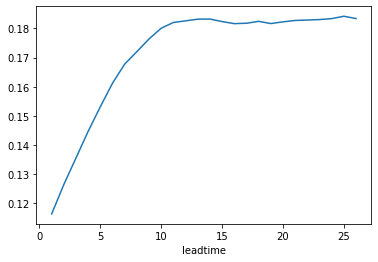

In [75]:
rps.plot()

This is raw model skill is not extremely hopeful. Seems that the three-week frequency (over all classes) at long leadtimes lacks skill. Some things too frequent, others (like blocking) too infrequent, and an overall drift in distances.

In [76]:
bs = agg_ids.stack('clustid').groupby(['leadtime','clustid']).apply(lambda df: mean_squared_error(df['observation'],df['forecast']))
bs = bs.unstack('clustid') # Not with binary observation but with probabilistic observation. so just mse distance.

In [103]:
# Alternative lead time dependent way. Not much change with just pooling the leadtimes.
#bs_clim = agg_ids.stack('clustid').groupby(['leadtime','clustid']).apply(lambda df: mean_squared_error(df['observation'],np.full(df['observation'].shape, fill_value = df['observation'].mean())))
#bs_clim = bs_clim.unstack('clustid')
#bss = pd.DataFrame(1 - bs.values / bs_clim.values, columns = bs.columns, index = bs.index)
#bs_clim.plot()

In [77]:
bs_clim = pd.Series(np.nan, index = obs_freqs_agg.index)
for clustid in obs_freqs_agg.index:
    oi = agg_ids.loc[:,('observation',clustid)]
    bs_clim.loc[clustid] = mean_squared_error(oi, np.full(oi.shape, fill_value = obs_freqs_agg.loc[clustid]))
bss = pd.DataFrame(1 - bs.values / bs_clim.values[np.newaxis,:], columns = bs.columns, index = bs.index)

Text(0.5, 1.0, 'frequency in 21-day period')

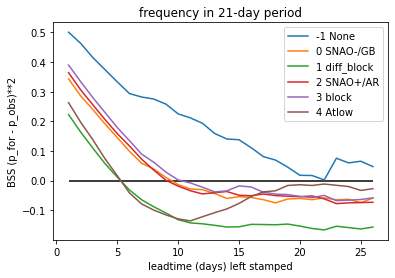

In [78]:
fig, ax = plt.subplots()
ax.hlines(y = 0, xmin = bss.index.min(), xmax = bss.index.max(), color = 'black')
for clustid in bss.columns:
    ax.plot(bss.index, bss.loc[:,clustid], label = f'{clustid} {code_table.loc[clustid]}')
ax.legend()
ax.set_ylabel('BSS (p_for - p_obs)**2')
ax.set_xlabel('leadtime (days) left stamped')
ax.set_title('frequency in 21-day period')

In [79]:
bias = agg_ids.stack('clustid').groupby(['leadtime','clustid']).apply(lambda df: np.mean(df['forecast'] - df['observation']))
bias = bias.unstack('clustid')

Text(0.5, 1.0, 'average frequency bias in 21-day period')

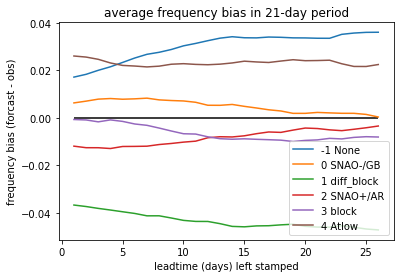

In [80]:
fig, ax = plt.subplots()
ax.hlines(y = 0, xmin = bias.index.min(), xmax = bias.index.max(), color = 'black')
for clustid in bias.columns:
    ax.plot(bias.index, bias.loc[:,clustid], label = f'{clustid} {code_table.loc[clustid]}')
ax.legend()
ax.set_ylabel('frequency bias (forcast - obs)')
ax.set_xlabel('leadtime (days) left stamped')
ax.set_title('average frequency bias in 21-day period')

The too infrequent blocking seems to be a problem indeed. Its skill is more limited here than in the daily assignments, where most were equal and did not extend beyond 10-12 days. Probably also limits the overall rps in predicting the distribution over classes. Only the Atlantic ridge regime seems to have more potential for sub-seasonal usability (12 days + 21 day period)